In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib notebook
%matplotlib inline

In [3]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/training')

In [4]:
import sys
sys.path.append(ROOT)

In [5]:
import torch
import pickle
import pandas as pd
import matplotlib.pylab as pylab

from utils.plot.abc_parameterizations.results import *

/Users/karlhajjar/Documents/projects/wide-networks/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set variables

In [6]:
L = 6
WIDTH = 1024
BASE_LR = 0.01
BATCH_SIZE = 512
BIAS = False
N_TRIALS = 5
MODEL_NAME = 'fc_ipllr' # 'fc_ipllr', 'standard_fc_ip', 'fc_muP', 'fc_ipllr_bias', 'fc_ip_non_centered'
DATASET = 'cifar10'  # 'mnist', 'cifar10'

if 'llr' in MODEL_NAME:
    N_WARMUP_STEPS = 1
else:
    N_WARMUP_STEPS = None

FONTSIZE = 12
FIGSIZE = (10, 6)

ACT_KEY_TO_NAME = {'relu': 'ReLU',
                   'gelu': 'GeLU',
                   'elu': 'ELU',
                   'tanh': 'tanh'}


experiments_dir = os.path.join(ROOT, 'experiments')
base_experiment = '{}_{}'.format(MODEL_NAME, DATASET)
fig_dir = os.path.join(ROOT, FIGURES_DIR, DATASET)

params = {'legend.fontsize': FONTSIZE,
         'axes.labelsize': FONTSIZE,
         'axes.titlesize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE}
pylab.rcParams.update(params)

## Process results

In [7]:
results = dict()
for activation in ACT_KEY_TO_NAME.keys():
    results[activation] = get_trial_results([L], [WIDTH], N_TRIALS, experiments_dir, base_experiment, activation, 
                                            BASE_LR, BATCH_SIZE, BIAS, N_WARMUP_STEPS)

In [30]:
results["relu"][6][1024][0]['validation'][0].keys()

dict_keys(['loss', 'likelihood', 'accuracy', 'log'])

In [36]:
epoch_res["relu"][6][1024][4]['validation'][0].keys()

dict_keys(['loss', 'likelihood', 'accuracy', 'log'])

In [8]:
epoch_res = dict()
step_res = dict()
for activation in ACT_KEY_TO_NAME.keys():
    epoch_res_, step_res_ = get_epoch_step_results_from_trials(results[activation], 
                                                               pop_keys=('lrs', 'all_outputs', 'all_losses'))
    epoch_res[activation] = epoch_res_
    step_res[activation] = step_res_

In [9]:
# generate dataframe for easy plotting with seaborn lineplot
results_df = pd.DataFrame(columns=['step', 'mean absolute output', 'loss', 'activation'])
key_to_metric_name_results = {'all_outputs': 'mean absolute output', 
                              'all_losses': 'loss'}

idx_start_trial = 0
for activation in step_res.keys():
    for trial in step_res[activation][L][WIDTH]:
        for i, metric_value in enumerate(trial['all_outputs']):
            results_df.loc[idx_start_trial + i, ['step', 'mean absolute output', 'loss', 'activation']] = \
                [i, trial['all_outputs'][i].item(), trial['all_losses'][i].item(), ACT_KEY_TO_NAME[activation]]
        idx_start_trial += len(trial['all_outputs'])

results_df.loss = results_df.loss.astype(float)
results_df['mean absolute output'] = results_df['mean absolute output'].astype(float)

## Plots

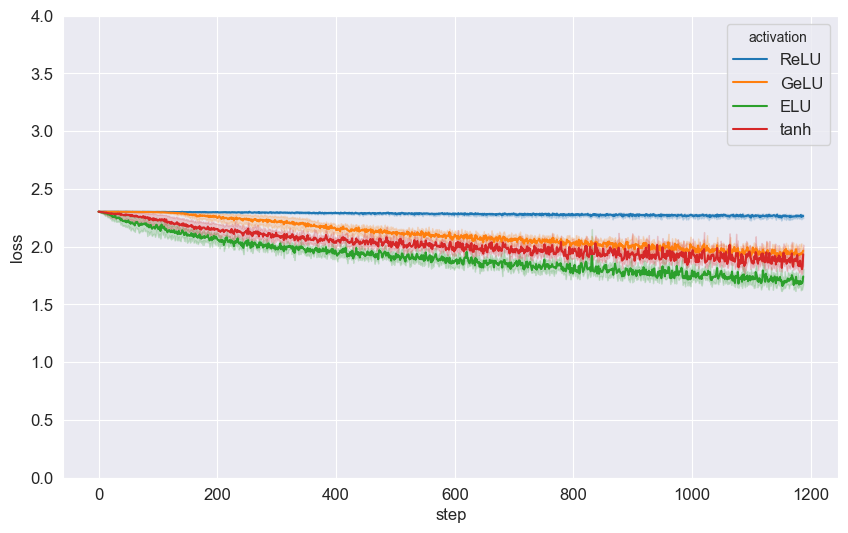

In [10]:
plt.figure(figsize=FIGSIZE)
plt.ylim(0, 4)

g = sns.lineplot(x="step", y="loss", hue="activation", data=results_df)

fig_path = os.path.join(fig_dir, '{}_loss.png'.format(MODEL_NAME))
plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

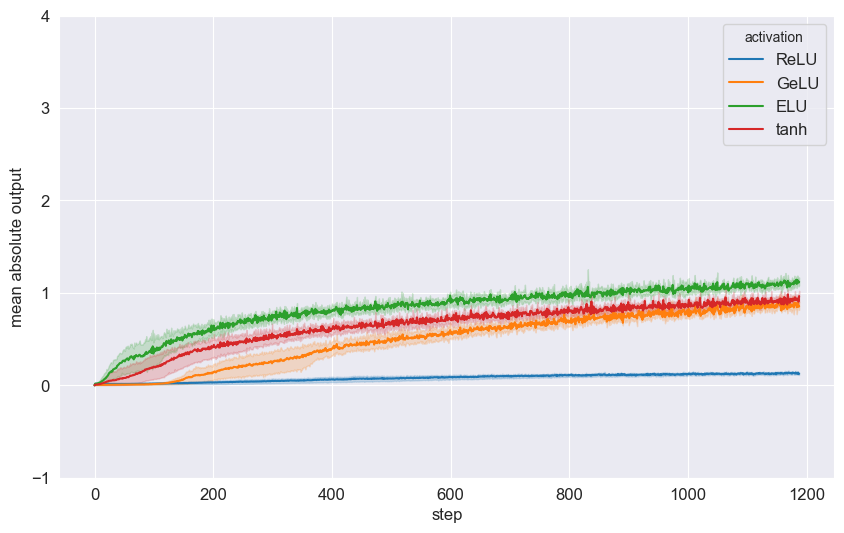

In [11]:
plt.figure(figsize=FIGSIZE)
plt.ylim(-1, 4)

g = sns.lineplot(x="step", y="mean absolute output", hue="activation", data=results_df)

fig_path = os.path.join(fig_dir, '{}_output.png'.format(MODEL_NAME))
plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)

## Test accuracies

In [12]:
test_accuracies = {activation: [results[activation][L][WIDTH][idx]['test'][0]['accuracy'] 
                                for idx in range(N_TRIALS)] 
                   for activation in ACT_KEY_TO_NAME.keys()}
test_accuracies

{'relu': [0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612,
  0.10000000149011612],
 'gelu': [0.2329999953508377,
  0.30140000581741333,
  0.26969999074935913,
  0.24279999732971191,
  0.24899999797344208],
 'elu': [0.3831999897956848,
  0.373199999332428,
  0.3686000108718872,
  0.3443000018596649,
  0.321399986743927],
 'tanh': [0.3010999858379364,
  0.24770000576972961,
  0.23819999396800995,
  0.24390000104904175,
  0.2937000095844269]}

In [13]:
for activation in ACT_KEY_TO_NAME.keys():
    print(activation, np.mean(test_accuracies[activation]))

relu 0.10000000149011612
gelu 0.2591799974441528
elu 0.35813999772071836
tanh 0.2649199992418289


In [37]:
170 * np.exp(-4) - 10

-6.88634138891519